In [49]:
import pandas as pd
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [50]:
train_df = pd.read_csv("train.csv")
val_df = pd.read_csv("val.csv")
test_df = pd.read_csv("test.csv")

train_df["split"] = "train"
val_df["split"] = "validation"
test_df["split"] = "test"

df = pd.concat([train_df, val_df, test_df], ignore_index=True)

In [51]:
def parse_and_pad_column(col, maxlen=200):
    vectors = df[col].apply(lambda x: np.array(eval(x)))
    padded = pad_sequences(vectors, maxlen=maxlen, padding='post', dtype='float32')
    return padded

max_len = 200

x1 = parse_and_pad_column("code1_vecMark", maxlen=max_len)
x2 = parse_and_pad_column("code2_vecMark", maxlen=max_len)
y = df["result"].values
splits = df["split"]

x1 = np.expand_dims(x1, axis=-1)
x2 = np.expand_dims(x2, axis=-1)

In [52]:
x1_train = x1[splits == "train"]
x2_train = x2[splits == "train"]
y_train = y[splits == "train"]

x1_val = x1[splits == "validation"]
x2_val = x2[splits == "validation"]
y_val = y[splits == "validation"]

x1_test = x1[splits == "test"]
x2_test = x2[splits == "test"]
y_test = y[splits == "test"]

In [53]:
from tensorflow.keras.optimizers import Adam

def build_branch(input_shape):
    input_layer = Input(shape=input_shape)
    x = Conv1D(128, 5, activation='relu', padding='same')(input_layer)
    x = GlobalMaxPooling1D()(x)
    return input_layer, x

input_shape = (max_len, 1)
input1, out1 = build_branch(input_shape)
input2, out2 = build_branch(input_shape)

merged = Concatenate()([out1, out2])
x = Dense(128, activation='relu')(merged)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=[input1, input2], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 200, 1)]             0         []                            
                                                                                                  
 input_14 (InputLayer)       [(None, 200, 1)]             0         []                            
                                                                                                  
 conv1d_12 (Conv1D)          (None, 200, 128)             768       ['input_13[0][0]']            
                                                                                                  
 conv1d_13 (Conv1D)          (None, 200, 128)             768       ['input_14[0][0]']            
                                                                                            

In [54]:
model.fit(
    [x1_train, x2_train], y_train,
    validation_data=([x1_val, x2_val], y_val),
    epochs=100,
    batch_size=32
)


Epoch 1/100
39/39 [==============================] - 1s 7ms/step - loss: 0.6912 - accuracy: 0.5504 - val_loss: 0.6951 - val_accuracy: 0.5000
Epoch 2/100
39/39 [==============================] - 0s 4ms/step - loss: 0.6893 - accuracy: 0.5520 - val_loss: 0.7001 - val_accuracy: 0.5000
Epoch 3/100
39/39 [==============================] - 0s 4ms/step - loss: 0.6881 - accuracy: 0.5520 - val_loss: 0.6975 - val_accuracy: 0.5000
Epoch 4/100
39/39 [==============================] - 0s 4ms/step - loss: 0.6885 - accuracy: 0.5520 - val_loss: 0.6949 - val_accuracy: 0.5000
Epoch 5/100
39/39 [==============================] - 0s 4ms/step - loss: 0.6865 - accuracy: 0.5520 - val_loss: 0.7131 - val_accuracy: 0.5000
Epoch 6/100
39/39 [==============================] - 0s 4ms/step - loss: 0.6878 - accuracy: 0.5520 - val_loss: 0.6926 - val_accuracy: 0.5000
Epoch 7/100
39/39 [==============================] - 0s 4ms/step - loss: 0.6868 - accuracy: 0.5520 - val_loss: 0.6940 - val_accuracy: 0.5000
Epoch 8/100
3

In [55]:
loss, accuracy = model.evaluate([x1_test, x2_test], y_test)
print(f"\nTest Accuracy: {accuracy:.4f}")

5/5 [==============================] - 0s 2ms/step - loss: 0.6225 - accuracy: 0.6129

Test Accuracy: 0.6129


5/5 [==============================] - 0s 2ms/step


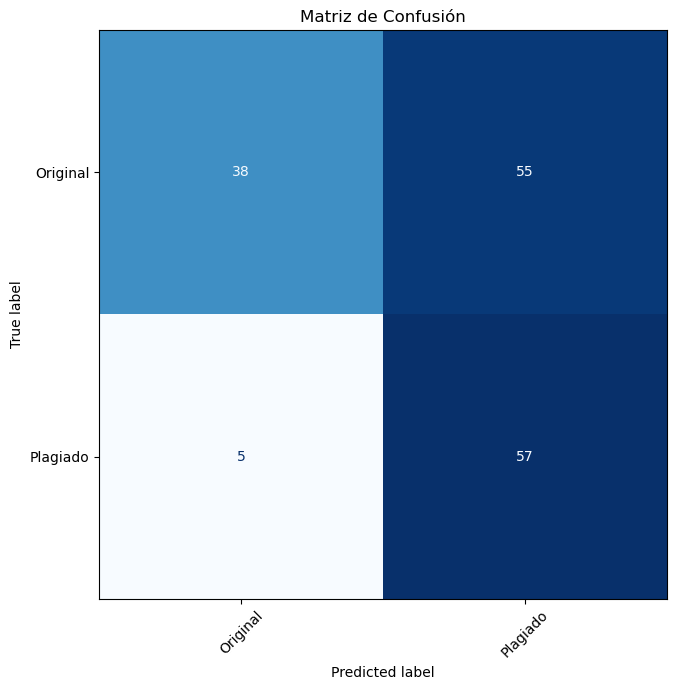


Reporte de clasificación:

              precision    recall  f1-score   support

    Original       0.88      0.41      0.56        93
    Plagiado       0.51      0.92      0.66        62

    accuracy                           0.61       155
   macro avg       0.70      0.66      0.61       155
weighted avg       0.73      0.61      0.60       155



In [56]:
from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay


y_pred = (model.predict([x1_test, x2_test]) > 0.5).astype(int).flatten()
labels = ["Original", "Plagiado"]

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(7, 7))
disp.plot(ax=ax, cmap="Blues", colorbar=False, values_format="d")
plt.xticks(rotation=45)
plt.title("Matriz de Confusión")
plt.tight_layout()
plt.show()

print("\nReporte de clasificación:\n")
print(classification_report(y_test, y_pred, target_names=labels))